In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import h5py
import random
import numpy as np
import sys
import pickle as pkl

from collections import Counter
from omegaconf import OmegaConf, DictConfig
import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, random_split
from torchtext.vocab import Vocab

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from sklearn.model_selection import train_test_split

from chord_rec.models.lit_seq2seq import LitSeq2Seq

from chord_rec.datasets.vec_datasets import Vec45Dataset

In [3]:
class CheckpointEveryNEpoch(pl.Callback):
    def __init__(self, start_epoc, ckpt_every_n = 1):
        self.start_epoc = start_epoc
        self.ckpt_every_n = ckpt_every_n

    def on_epoch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train epoch """
        # file_path = f"{trainer.logger.log_dir}/checkpoints/epoch={trainer.current_epoch}.pt"
        epoch = trainer.current_epoch
        if epoch >= self.start_epoc and epoch % self.ckpt_every_n == 0:
            ckpt_path = f"{trainer.logger.log_dir}/checkpoints/epoch={epoch}.ckpt"
            trainer.save_checkpoint(ckpt_path)

In [25]:
ckp_dir = "D:\\Documents\\2021Spring\\ChordSymbolRec\\chord_rec\\logs\\equal_data\\version_7"
hparams_path = os.path.join(ckp_dir, "hparams.yaml")
checkpoint_path = os.path.join(ckp_dir, "checkpoints", "epoch=131-step=18875.ckpt")

all_conf = OmegaConf.load(hparams_path)
conf = all_conf.configs
data_conf = conf.dataset
seed = conf.experiment.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if conf.experiment.device == "gpu" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

data_root = conf.dataset.directory
dataset_name = conf.dataset.name

In [26]:
# data_conf.fpath = "D:\\Documents\\2021Spring\\ChordSymbolRec\\all_new_pickle\\s2s\\sears_org_s2s_sorted.pkl"

In [27]:
data = pkl.load(open(data_conf.fpath, "rb"))

note_seq, chord_seq = [],[]
max_seq_len = 0
data_num = 0
for file in data:
    data_num += len(file)
    for window in file:
        note_seq.append(window[0])
        chord_seq.append(window[1])
        max_seq_len = max(max_seq_len, len(window[1]))
        
note_padding_vec = np.full(len(note_seq[0][0]), -1).reshape(1,-1) # should be 45; not sure if -1 is good
note_ending_vec = np.ones(len(note_seq[0][0])).reshape(1,-1) # should be 45
note_starting_vec = np.zeros(len(note_seq[0][0])).reshape(1,-1) # should be 45

chord_start = "<sos>"
chord_padding = "<pad>"
chord_end = "<eos>"

padded_note_seq = []
padded_chord_seq = []

eval_masks = []

for i in range(len(note_seq)):
    len_diff = max_seq_len - len(note_seq[i])

    temp_note_vec = np.vstack((note_starting_vec, np.array(note_seq[i]), note_ending_vec, np.repeat(note_padding_vec, len_diff , axis = 0)))
    padded_note_seq.append(temp_note_vec)

    eval_masks.append([False] + [True for _ in range(len(note_seq[i]))] + [False for _ in range(len_diff+1)])
    temp_chord_vec = np.hstack((chord_start, np.array(chord_seq[i]), chord_end, np.repeat(chord_padding, len_diff , axis = 0)))
    padded_chord_seq.append(temp_chord_vec)

eval_masks = np.array(eval_masks)
stacked_note_seq = np.stack(padded_note_seq, axis = 0)
stacked_chord_seq = np.vstack(padded_chord_seq)

note_vec = np.asarray(stacked_note_seq, dtype = np.float32)
chord_vocab = Vocab(Counter(list(stacked_chord_seq.flatten())))

vec_size = note_vec.shape[-1]
vocab_size = len(chord_vocab.stoi)

assert data_conf.val_ratio + data_conf.test_ratio <= 0.6, "At least 40 percent of the data needed for training"

dataset = Vec45Dataset(note_vec, stacked_chord_seq, eval_masks, chord_vocab)


train_ratio = 1 - data_conf.val_ratio - data_conf.test_ratio

train_len = int(len(dataset)*train_ratio)
val_len = int(len(dataset)*data_conf.val_ratio)
test_len = len(dataset) - train_len - val_len

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len], 
#                                                 generator=torch.Generator().manual_seed(seed)
#                                                )
train_dataset, val_dataset, test_dataset = Subset(dataset, range(train_len)), Subset(dataset, range(train_len, train_len+val_len)), Subset(dataset, range(train_len+val_len, len(dataset)))


train_loader = DataLoader(train_dataset, batch_size =data_conf.batch_size, shuffle = data_conf.shuffle_train, num_workers = data_conf.num_workers, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size = data_conf.batch_size, shuffle = data_conf.shuffle_val, num_workers = data_conf.num_workers, drop_last = True)
test_loader =  DataLoader(test_dataset, batch_size = data_conf.batch_size, shuffle = data_conf.shuffle_val, num_workers = data_conf.num_workers, drop_last = True)

MAX_LEN = max_seq_len + 2

if conf.model.type == "attn_s2s":
    model = LitSeq2Seq(vec_size, MAX_LEN, chord_vocab, conf)
else:
    raise NotImplementedError

In [28]:
# stacked_chord_seq1 = stacked_chord_seq
# np.sum(stacked_chord_seq1 == stacked_chord_seq)/np.product(stacked_chord_seq1.shape)

In [29]:
model = LitSeq2Seq.load_from_checkpoint(checkpoint_path, chord_vocab = chord_vocab)

In [30]:
epochs = conf.training.warm_up + conf.training.decay_run + conf.training.post_run
tb_logger = pl_loggers.TensorBoardLogger(conf.logging.output_dir, name = conf.experiment.objective)
trainer = pl.Trainer()

GPU available: True, used: False
TPU available: None, using: 0 TPU cores


In [ ]:
trainer.test(model, test_dataloaders = test_loader)

 47%|██████████████████████████████████▉                                        | 20543/44101 [02:10<03:18, 118.40it/s]

In [131]:
from tqdm.notebook import tqdm

In [141]:
model.to(device)
model.eval()
all_pred2 = []
all_label2 = []
eval_masks = []
for idx, (note, chord, mask) in enumerate(tqdm(test_loader)):
        pred = model(note.to(device), chord.long().to(device), teacher_forcing = False, start_idx = chord_vocab.stoi["<sos>"])
        pred = pred.detach().cpu().numpy().argmax(axis = -1)
        
        label = chord.detach().cpu().numpy()
        pred[:,0] = np.full(len(pred), chord_vocab.stoi["<sos>"])
        all_pred2.append(dataset.vec_decode(pred))
        all_label2.append(dataset.vec_decode(label))
        eval_masks.append(mask.detach().cpu().numpy())

In [142]:
print(len(test_dataset))

1176


In [143]:
all_pred2 = np.vstack(all_pred2)
all_label2 = np.vstack(all_label2)

In [144]:
all_pred2[0]

array(['<sos>', 'B dominant seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh', 'F half-diminished seventh',
       'F half-diminished seventh'], dtype='<U25')

In [145]:
all_label2[0]

array(['<sos>', 'B dominant seventh', 'B dominant seventh', 'E major',
       'B major', 'E major', 'B major', 'E major', 'E major', 'E major',
       'B major', 'B major', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>', '<pad>'], dtype='<U27')

In [14]:
decoded_preds = all_pred2
decoded_chords = all_label2

In [15]:
decoded_preds

array([['<sos>', 'Eb major', 'Eb major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'Ab major', 'C major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'F major', 'F major', ..., '<eos>', '<eos>', '<eos>'],
       ...,
       ['<sos>', 'B major', 'B major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'E major', 'E major', ..., '<eos>', '<eos>', '<eos>'],
       ['<sos>', 'E major', 'E major', ..., '<eos>', '<eos>', '<eos>']],
      dtype='<U27')

In [16]:
eval_masks = np.vstack(eval_masks)

In [17]:
# mask = (decoded_preds != "<sos>") & (decoded_preds != "<eos>") & (decoded_preds != "<pad>")
mask = eval_masks
masked_preds = decoded_preds[mask]
masked_chords = decoded_chords[mask]

print(np.sum(masked_preds == masked_chords) / len(masked_chords))

0.781286674490558


In [24]:
masked_preds

array(['Eb major', 'Eb major', 'Eb major', ..., 'F# major',
       'F# dominant seventh', 'B major'], dtype='<U27')

In [25]:
masked_chords

array(['Eb major', 'Eb major', 'Eb major', ..., 'F# dominant seventh',
       'F# dominant seventh', 'B major'], dtype='<U27')

In [18]:
# import pickle
# pickle.dump({"preds":all_pred2, "labels": all_label2 }, open("examples/output/haydn_red1_preds.pk", "wb"))

In [19]:
masked_preds == masked_chords

array([ True,  True,  True, ..., False,  True,  True])

In [20]:
# SEPERATE EVALUATION OF ROOT AND QUALITY AFTER DECODING
# seperate all pred 
root_preds = decoded_preds.copy()
quality_preds = decoded_preds.copy()
for r_id in range(decoded_preds.shape[0]):
    for c_id in range(decoded_preds.shape[1]):
        sp = decoded_preds[r_id, c_id].split(' ')
        root_preds[r_id, c_id] = sp[0]
        quality_preds[r_id, c_id] = ' '.join(sp[1:])
    
root_labels = decoded_chords.copy()
quality_labels = decoded_chords.copy()
for r_id in range(decoded_chords.shape[0]):
    for c_id in range(decoded_chords.shape[1]):
        sp = decoded_chords[r_id, c_id].split(' ')
        root_labels[r_id, c_id] = sp[0]
        quality_labels[r_id, c_id] = ' '.join(sp[1:])
# # seperate all lable 
# root_labels = []
# quality_labels = []
# for c in decoded_chords:
#     sp = c.split(' ')
#     root_labels.append(sp[0])
#     quality_labels.append(' '.join(sp[1:]))
    
# root_labels = np.asarray(root_labels)
# quality_labels = np.asarray(quality_labels)

In [21]:
mask = (root_preds != "<sos>") & (root_preds != "<eos>") & (root_preds != "<pad>")
root_preds = root_preds[mask]
quality_preds = quality_preds[mask]
root_label = root_labels[mask]
quality_labels = quality_labels[mask]

In [22]:
np.sum(root_preds == root_label) / len(root_preds)

0.8717948717948718

In [23]:
np.sum(quality_preds == quality_labels) / len(quality_preds)

0.8061097478573207

# Confusion Matrix

In [58]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [59]:
co = Counter(masked_chords)

In [60]:
most_common_chord = list(list(zip(*co.most_common(20)))[0])

In [61]:
for i in range(len(masked_preds)):
    if masked_preds[i] not in most_common_chord:
        masked_preds[i] = "others"
    if masked_chords[i] not in most_common_chord:
        masked_chords[i] = "others"

In [62]:
cm = confusion_matrix(masked_chords, masked_preds, normalize = "true", labels = most_common_chord + ["others"])

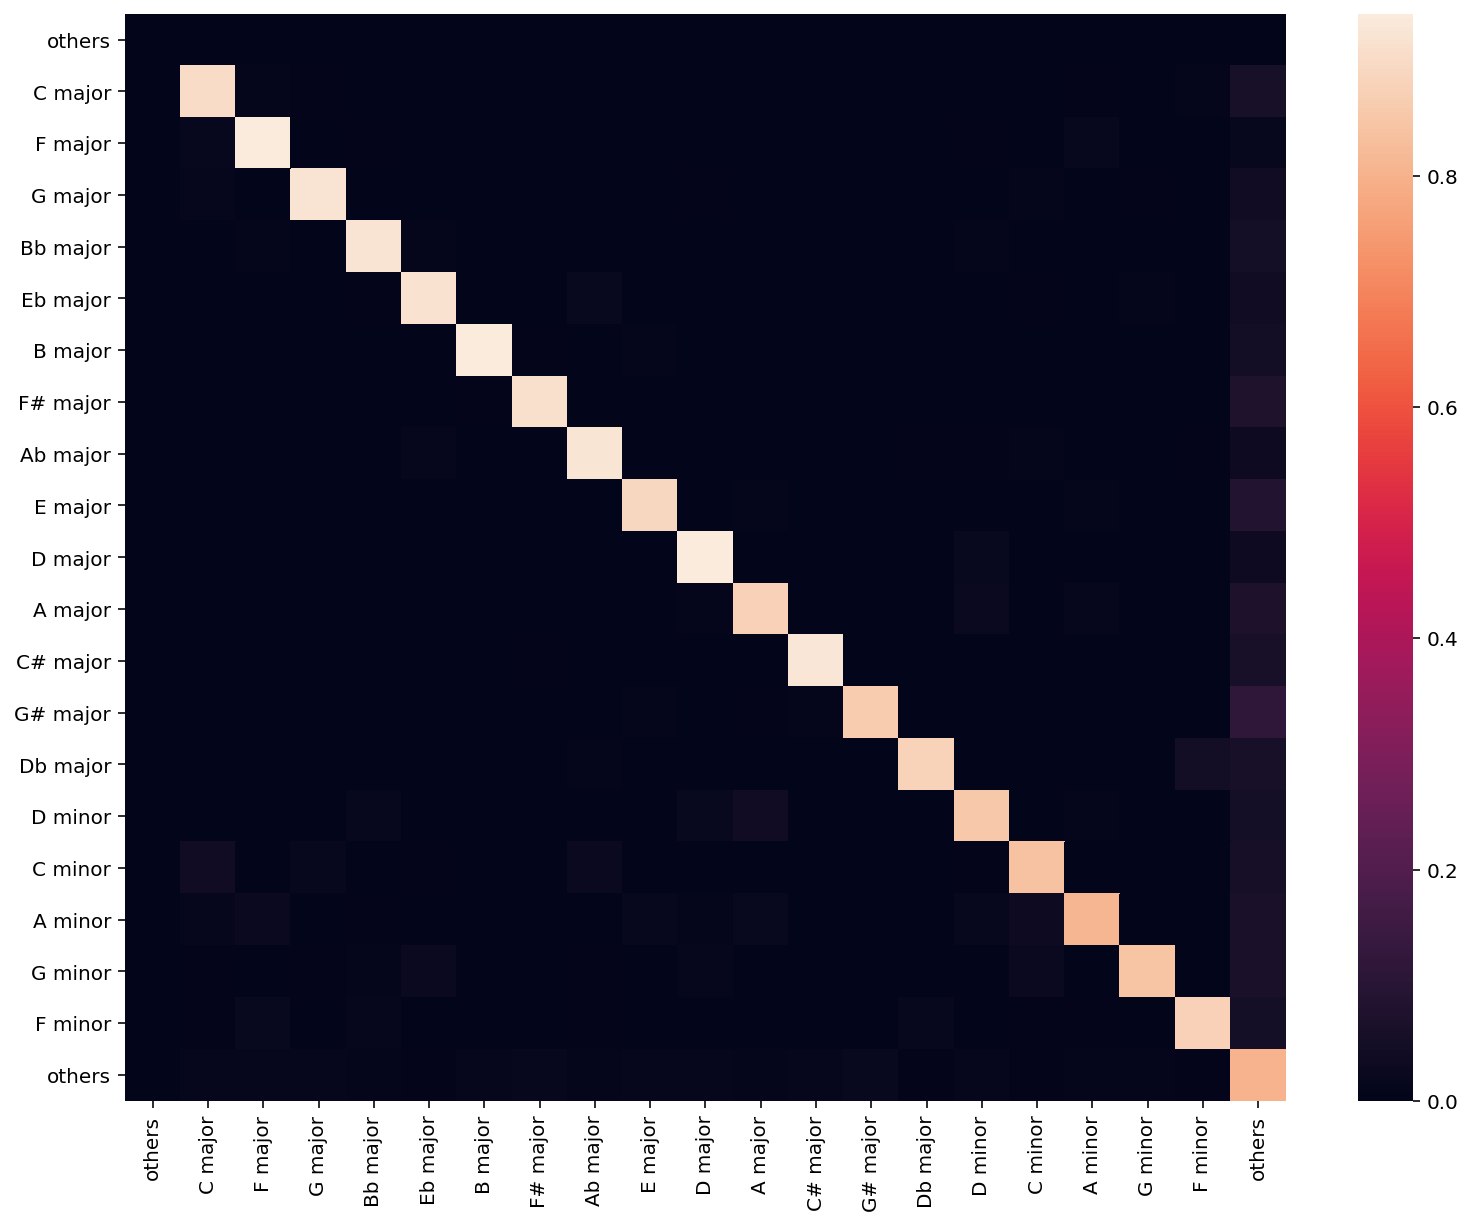

In [63]:
fig, ax = plt.subplots(figsize=(13,10)) 

sn.heatmap(cm, annot=False)
ax.set_xticklabels(most_common_chord + ["others"])
ax.set_yticklabels(most_common_chord + ["others"])
plt.yticks(rotation=0) 
plt.xticks(rotation="vertical") 
plt.show()
fig.savefig("confusion_bachhaydn_baseline.pdf", format = "pdf")

In [40]:
symbol, num = list(zip(*co.most_common(50)))
symbol = list(symbol)
num = list(num)

In [41]:
symbol += ['others']
num += [np.sum(list(co.values())) - np.sum(num)]

In [42]:
num/=np.sum(num)

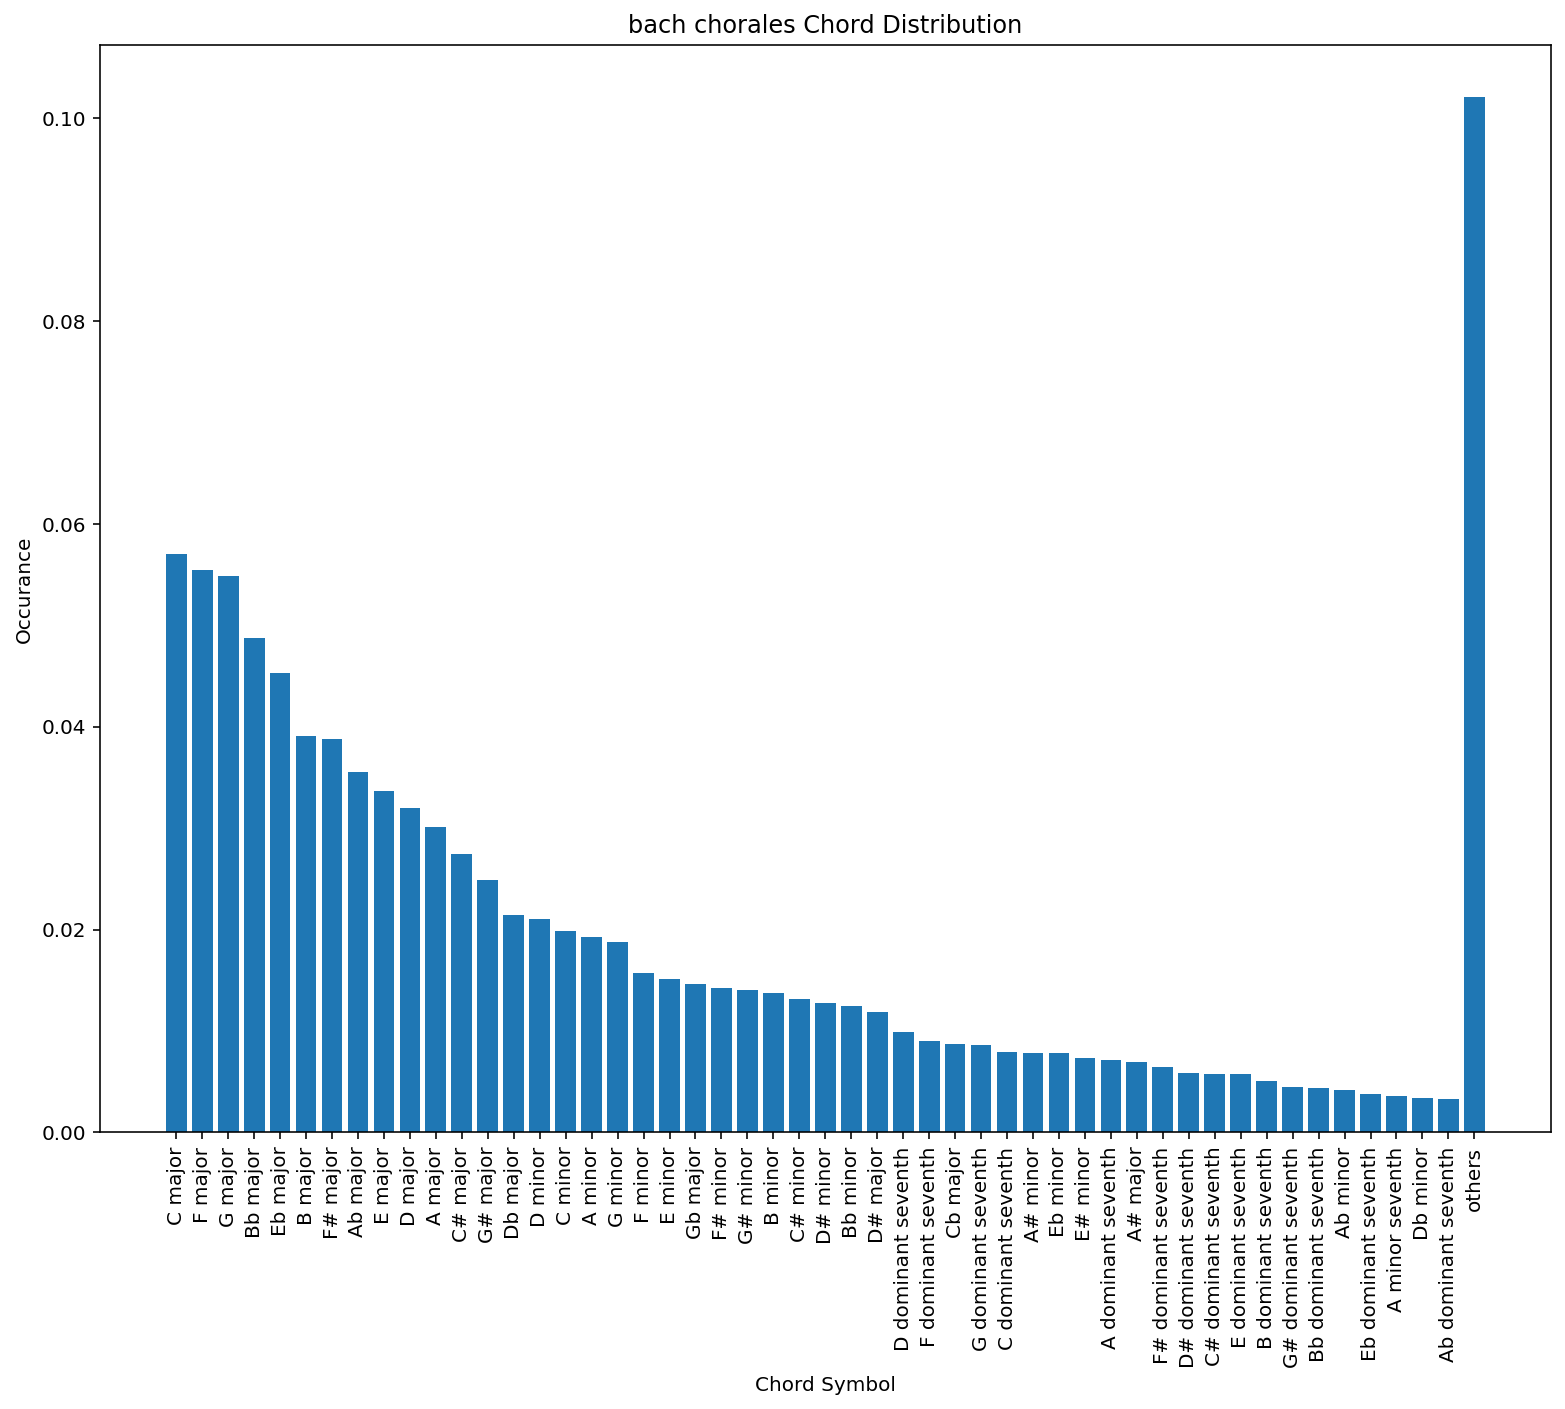

In [43]:
plt.subplots(figsize=(13,10)) 
x_pos = [i for i, _ in enumerate(symbol)]

plt.bar(x_pos, num)
plt.xlabel("Chord Symbol")
plt.ylabel("Occurance")
plt.title("bach chorales Chord Distribution")

plt.xticks(x_pos, symbol, rotation = "vertical")

plt.show()